# pyfit demo

## Autograd engine

In [1]:
from pyfit.engine import Tensor

### Reverse-mode autodiff

In [2]:
x = Tensor(1.0)
z = 2 * x + 2 + x
q = z + z * x
h = z * z
y = h + q + q * x
print(y.data) # 45.0
y.backward()
print(x.grad) # 62.0 (the numerical value of dy/dx)

[[45.]]
[[62.]]


### Computation graph

In [3]:
# pip install graphviz
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    nodes, edges = trace(root)
    dot = Digraph(format='png')
    
    for n in nodes:
        dot.node(name=str(id(n)), label = f"{{ data {n.data} | grad {n.grad} }}", shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

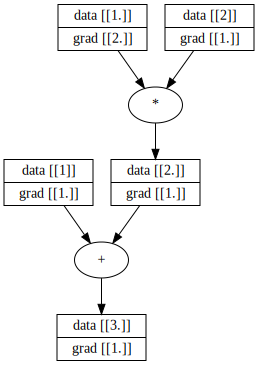

In [4]:
x = Tensor(1.0)
y = (x * 2 + 1)
y.backward()
draw_dot(y)

## Neural network API

### Single neuron

In [5]:
import random
from pyfit.nn import Neuron

random.seed(1337)
n = Neuron(2, activation='sigmoid')
print(n)
print(n.parameters())

<function sigmoid at 0x7f525c81e4c0> Neuron(2)
[Tensor(data=[[-0.02335474]
 [-0.54376067]], grad=[[0.]
 [0.]]), Tensor(data=[[0.74386784]], grad=[[0.]])]


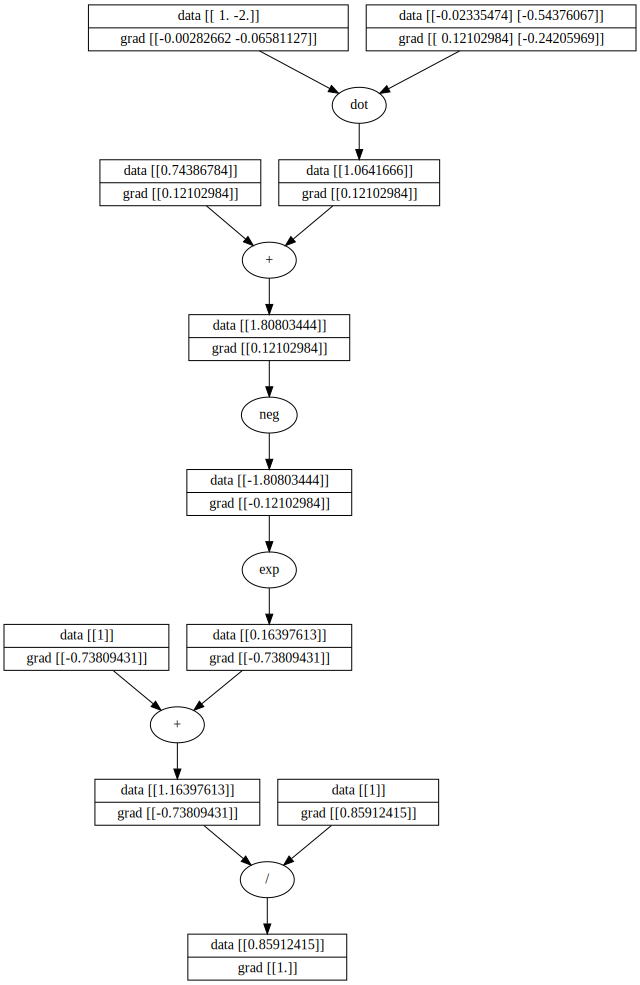

In [6]:
n.zero_grad()
x = Tensor([1.0, -2.0])
y = n(x)
y.backward()
draw_dot(y)

### Learning a line: y = 2 * x + 1

In [7]:
from pyfit.engine import Tensor
from pyfit.nn import Sequential, Dense
from pyfit.optim import SGD
from pyfit.loss import mean_squared_error
from pyfit.train import Trainer
from pyfit.data import BatchIterator

inputs = Tensor([[x] for x in range(10)])
targets = Tensor([[2*x+1] for x in range(10)])

n = Neuron(1, activation='linear')
optimizer = SGD(n.parameters(), learning_rate=0.01)

for epoch in range(100):
    optimizer.zero_grad()
    epoch_loss = 0
    for i in range(10):
        output = n(inputs[i])
        loss = mean_squared_error(output, targets[i])
        epoch_loss += loss.data[0, 0]
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"epoch: {epoch}, loss: {epoch_loss}, w: {n.w.data[0,0]}, b: {n.b.data[0,0]}")
print(f"w: {n.w.data[0,0]}, b: {n.b.data[0,0]}")

epoch: 0, loss: 99.37652198117347, w: 1.4888936202823106, b: 1.6841544518764384
epoch: 10, loss: 0.022159022043255948, w: 1.9865415657577343, b: 1.0497010528661361
epoch: 20, loss: 3.750716630602305e-05, w: 1.9994463272899707, b: 1.0020447363911862
epoch: 30, loss: 6.348136747765127e-08, w: 1.999977221814413, b: 1.0000841207886801
epoch: 40, loss: 1.0744304100264775e-10, w: 1.9999990629017297, b: 1.000003460742967
epoch: 50, loss: 1.8184874391973768e-13, w: 1.9999999614476245, b: 1.0000001423755298
epoch: 60, loss: 3.077814563502305e-16, w: 1.9999999984139485, b: 1.0000000058573528
epoch: 70, loss: 5.209221165645804e-19, w: 1.9999999999347498, b: 1.0000000002409724
epoch: 80, loss: 8.81623713820502e-22, w: 1.9999999999973155, b: 1.000000000009914
epoch: 90, loss: 1.4845431380391281e-24, w: 1.99999999999989, b: 1.0000000000004072
w: 1.9999999999999931, b: 1.000000000000024


### Learning XOR

In [8]:
inputs = Tensor([[0, 0], [0, 1], [1, 0], [1, 1]])
targets = Tensor([[0], [1], [1], [0]])

print(inputs.shape)
print(targets.shape)

(4, 2)
(4, 1)


In [9]:
model = Sequential()
model.add(Dense(2, 4, activation='sigmoid'))
model.add(Dense(4, 1, activation='sigmoid'))
print(model)
print(f"Number of parameters: {len(model.parameters())}")

MLP of [Layer of <function sigmoid at 0x7f525c81e4c0> Neurons(2), Layer of <function sigmoid at 0x7f525c81e4c0> Neurons(4)]
Number of parameters: 4


In [10]:
optimizer = SGD(model.parameters(), learning_rate=0.1)
loss = mean_squared_error
batch = BatchIterator(inputs, targets, batch_size=4, shuffle=True)

trainer = Trainer(model, optimizer, loss)
_ = trainer.fit(batch, num_epochs=10000, verbose=True)

model(inputs)

Epoch [1/10000], loss: 0.255869, accuracy: 50.00%
Epoch [11/10000], loss: 0.254356, accuracy: 50.00%
Epoch [21/10000], loss: 0.253452, accuracy: 50.00%
Epoch [31/10000], loss: 0.252911, accuracy: 50.00%
Epoch [41/10000], loss: 0.252584, accuracy: 50.00%
Epoch [51/10000], loss: 0.252381, accuracy: 50.00%
Epoch [61/10000], loss: 0.252251, accuracy: 25.00%
Epoch [71/10000], loss: 0.252163, accuracy: 25.00%
Epoch [81/10000], loss: 0.252099, accuracy: 50.00%
Epoch [91/10000], loss: 0.252050, accuracy: 50.00%
Epoch [101/10000], loss: 0.252009, accuracy: 50.00%
Epoch [111/10000], loss: 0.251974, accuracy: 50.00%
Epoch [121/10000], loss: 0.251941, accuracy: 50.00%
Epoch [131/10000], loss: 0.251910, accuracy: 50.00%
Epoch [141/10000], loss: 0.251880, accuracy: 50.00%
Epoch [151/10000], loss: 0.251851, accuracy: 50.00%
Epoch [161/10000], loss: 0.251822, accuracy: 50.00%
Epoch [171/10000], loss: 0.251794, accuracy: 50.00%
Epoch [181/10000], loss: 0.251767, accuracy: 50.00%
Epoch [191/10000], loss

Epoch [1581/10000], loss: 0.249244, accuracy: 50.00%
Epoch [1591/10000], loss: 0.249229, accuracy: 50.00%
Epoch [1601/10000], loss: 0.249214, accuracy: 50.00%
Epoch [1611/10000], loss: 0.249199, accuracy: 50.00%
Epoch [1621/10000], loss: 0.249184, accuracy: 50.00%
Epoch [1631/10000], loss: 0.249169, accuracy: 50.00%
Epoch [1641/10000], loss: 0.249154, accuracy: 50.00%
Epoch [1651/10000], loss: 0.249139, accuracy: 50.00%
Epoch [1661/10000], loss: 0.249124, accuracy: 50.00%
Epoch [1671/10000], loss: 0.249109, accuracy: 50.00%
Epoch [1681/10000], loss: 0.249094, accuracy: 50.00%
Epoch [1691/10000], loss: 0.249079, accuracy: 50.00%
Epoch [1701/10000], loss: 0.249064, accuracy: 50.00%
Epoch [1711/10000], loss: 0.249049, accuracy: 50.00%
Epoch [1721/10000], loss: 0.249033, accuracy: 50.00%
Epoch [1731/10000], loss: 0.249018, accuracy: 75.00%
Epoch [1741/10000], loss: 0.249003, accuracy: 75.00%
Epoch [1751/10000], loss: 0.248987, accuracy: 75.00%
Epoch [1761/10000], loss: 0.248972, accuracy: 

Epoch [3141/10000], loss: 0.245563, accuracy: 75.00%
Epoch [3151/10000], loss: 0.245522, accuracy: 75.00%
Epoch [3161/10000], loss: 0.245480, accuracy: 75.00%
Epoch [3171/10000], loss: 0.245437, accuracy: 75.00%
Epoch [3181/10000], loss: 0.245395, accuracy: 75.00%
Epoch [3191/10000], loss: 0.245351, accuracy: 75.00%
Epoch [3201/10000], loss: 0.245308, accuracy: 75.00%
Epoch [3211/10000], loss: 0.245264, accuracy: 75.00%
Epoch [3221/10000], loss: 0.245219, accuracy: 75.00%
Epoch [3231/10000], loss: 0.245174, accuracy: 75.00%
Epoch [3241/10000], loss: 0.245129, accuracy: 75.00%
Epoch [3251/10000], loss: 0.245083, accuracy: 75.00%
Epoch [3261/10000], loss: 0.245037, accuracy: 75.00%
Epoch [3271/10000], loss: 0.244990, accuracy: 75.00%
Epoch [3281/10000], loss: 0.244943, accuracy: 75.00%
Epoch [3291/10000], loss: 0.244896, accuracy: 75.00%
Epoch [3301/10000], loss: 0.244848, accuracy: 75.00%
Epoch [3311/10000], loss: 0.244799, accuracy: 75.00%
Epoch [3321/10000], loss: 0.244750, accuracy: 

Epoch [4701/10000], loss: 0.230089, accuracy: 75.00%
Epoch [4711/10000], loss: 0.229892, accuracy: 75.00%
Epoch [4721/10000], loss: 0.229694, accuracy: 75.00%
Epoch [4731/10000], loss: 0.229493, accuracy: 75.00%
Epoch [4741/10000], loss: 0.229291, accuracy: 75.00%
Epoch [4751/10000], loss: 0.229086, accuracy: 75.00%
Epoch [4761/10000], loss: 0.228879, accuracy: 75.00%
Epoch [4771/10000], loss: 0.228671, accuracy: 75.00%
Epoch [4781/10000], loss: 0.228460, accuracy: 75.00%
Epoch [4791/10000], loss: 0.228248, accuracy: 75.00%
Epoch [4801/10000], loss: 0.228033, accuracy: 75.00%
Epoch [4811/10000], loss: 0.227816, accuracy: 75.00%
Epoch [4821/10000], loss: 0.227597, accuracy: 75.00%
Epoch [4831/10000], loss: 0.227377, accuracy: 75.00%
Epoch [4841/10000], loss: 0.227153, accuracy: 75.00%
Epoch [4851/10000], loss: 0.226928, accuracy: 75.00%
Epoch [4861/10000], loss: 0.226701, accuracy: 75.00%
Epoch [4871/10000], loss: 0.226471, accuracy: 75.00%
Epoch [4881/10000], loss: 0.226239, accuracy: 

Epoch [6261/10000], loss: 0.163684, accuracy: 100.00%
Epoch [6271/10000], loss: 0.162956, accuracy: 100.00%
Epoch [6281/10000], loss: 0.162225, accuracy: 100.00%
Epoch [6291/10000], loss: 0.161490, accuracy: 100.00%
Epoch [6301/10000], loss: 0.160752, accuracy: 100.00%
Epoch [6311/10000], loss: 0.160011, accuracy: 100.00%
Epoch [6321/10000], loss: 0.159266, accuracy: 100.00%
Epoch [6331/10000], loss: 0.158517, accuracy: 100.00%
Epoch [6341/10000], loss: 0.157766, accuracy: 100.00%
Epoch [6351/10000], loss: 0.157011, accuracy: 100.00%
Epoch [6361/10000], loss: 0.156253, accuracy: 100.00%
Epoch [6371/10000], loss: 0.155492, accuracy: 100.00%
Epoch [6381/10000], loss: 0.154728, accuracy: 100.00%
Epoch [6391/10000], loss: 0.153961, accuracy: 100.00%
Epoch [6401/10000], loss: 0.153191, accuracy: 100.00%
Epoch [6411/10000], loss: 0.152419, accuracy: 100.00%
Epoch [6421/10000], loss: 0.151644, accuracy: 100.00%
Epoch [6431/10000], loss: 0.150866, accuracy: 100.00%
Epoch [6441/10000], loss: 0.

Epoch [7821/10000], loss: 0.056887, accuracy: 100.00%
Epoch [7831/10000], loss: 0.056470, accuracy: 100.00%
Epoch [7841/10000], loss: 0.056057, accuracy: 100.00%
Epoch [7851/10000], loss: 0.055648, accuracy: 100.00%
Epoch [7861/10000], loss: 0.055243, accuracy: 100.00%
Epoch [7871/10000], loss: 0.054841, accuracy: 100.00%
Epoch [7881/10000], loss: 0.054443, accuracy: 100.00%
Epoch [7891/10000], loss: 0.054049, accuracy: 100.00%
Epoch [7901/10000], loss: 0.053658, accuracy: 100.00%
Epoch [7911/10000], loss: 0.053271, accuracy: 100.00%
Epoch [7921/10000], loss: 0.052887, accuracy: 100.00%
Epoch [7931/10000], loss: 0.052508, accuracy: 100.00%
Epoch [7941/10000], loss: 0.052131, accuracy: 100.00%
Epoch [7951/10000], loss: 0.051758, accuracy: 100.00%
Epoch [7961/10000], loss: 0.051389, accuracy: 100.00%
Epoch [7971/10000], loss: 0.051023, accuracy: 100.00%
Epoch [7981/10000], loss: 0.050660, accuracy: 100.00%
Epoch [7991/10000], loss: 0.050301, accuracy: 100.00%
Epoch [8001/10000], loss: 0.

Epoch [9361/10000], loss: 0.022371, accuracy: 100.00%
Epoch [9371/10000], loss: 0.022264, accuracy: 100.00%
Epoch [9381/10000], loss: 0.022158, accuracy: 100.00%
Epoch [9391/10000], loss: 0.022053, accuracy: 100.00%
Epoch [9401/10000], loss: 0.021949, accuracy: 100.00%
Epoch [9411/10000], loss: 0.021845, accuracy: 100.00%
Epoch [9421/10000], loss: 0.021742, accuracy: 100.00%
Epoch [9431/10000], loss: 0.021640, accuracy: 100.00%
Epoch [9441/10000], loss: 0.021539, accuracy: 100.00%
Epoch [9451/10000], loss: 0.021438, accuracy: 100.00%
Epoch [9461/10000], loss: 0.021339, accuracy: 100.00%
Epoch [9471/10000], loss: 0.021240, accuracy: 100.00%
Epoch [9481/10000], loss: 0.021141, accuracy: 100.00%
Epoch [9491/10000], loss: 0.021044, accuracy: 100.00%
Epoch [9501/10000], loss: 0.020947, accuracy: 100.00%
Epoch [9511/10000], loss: 0.020851, accuracy: 100.00%
Epoch [9521/10000], loss: 0.020756, accuracy: 100.00%
Epoch [9531/10000], loss: 0.020661, accuracy: 100.00%
Epoch [9541/10000], loss: 0.

Tensor(data=[[0.09080197]
 [0.84730487]
 [0.88064229]
 [0.14765827]], grad=[[0.]
 [0.]
 [0.]
 [0.]])